##Classifying the CIFAR-10 Dataset
**Goal**: Get the best possible accuracy on classifying the CIRFAR-10 datasetset using a feedfoward neural network with SGD. 


To increase accuracy we tune hyperparameters as necessary and adjust the following aspects:


*  Normalization approaches
*  Weight initialization
*  Architecture
*  Activation function
*  Loss function
*  L1 and L2 Regularization



To begin, we import some libraries.

In [ ]:
# our handy dandy libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelBinarizer
from sklearn.preprocessing import normalize
from tensorflow.keras.datasets import cifar10

##Stochastic Gradient Descent
In Homework #3 we used a feedfoward neural network on the MNIST dataset using 5000 images. With this method I acheived a testing accuracy of 88% however, this method was very slow, even on only 5000 images. If I were to use the full MNIST dataset it would have taken an unreasonable ammount of time. To address this, we implement the feedforward neural net with stochastic gradient descent (SGD). SGD makes weight updates based on random batches of datapoints rather than each datapoint, saving lots of computation time.

To do this, we need to add a function to the feed forward NN class that will create mini-batches of images.

In [ ]:
class FeedforwardNeuralNetworkSGD:
    
    def __init__(self, layers, alpha = 0.1, batchSize = 32):
        """ ** layers is a vector [a, b, c, ...] with the number of nodes in each layer
          ** alpha is the learning rate.  

          This function initializes parameters for use in the class and 
          initializes the weights randomly """
        # list of weight matrices between layers
        self.W = []
        
        # network architecture will be a vector of numbers of nodes for each layer
        self.layers = layers
        
        # learning rate
        self.alpha = alpha
        
        # batch size
        self.batchSize = batchSize
        
        # initialize the weights (randomly) -- this is our initial guess for gradient descent
        # initialize the weights between layers (up to the next-to-last one) as normal random variables
        for i in np.arange(0, len(layers) - 2):
            self.W.append(np.random.randn(layers[i] + 1, layers[i + 1] + 1))

            
        # initialize weights between the last two layers (we don't want bias for the last one)
        self.W.append(np.random.randn(layers[-2] + 1, layers[-1]))
        
    # define the sigmoid activation
    def sigmoid(self, x):
        return 1.0 / (1 + np.exp(-x))
    
    # define the sigmoid derivative (where z is the output of a sigmoid)
    def sigmoidDerivative(self, z):
        return z * (1 - z)
    
    def getNextBatch(self, X, y, batchSize):
        """ ** Called by the fit function
          ** returns the next batch of images of size batchSize

          Each batch will then be fed forward, then we backpropogate and update 
          the weights accordingly  """

        for i in np.arange(0, X.shape[0], batchSize):
            yield (X[i:i + batchSize], y[i:i + batchSize])
    
    # fit the model
    def fit(self, X, y, epochs = 10000, update = 1000):
        # add a column of ones to the end of X
        X = np.hstack((X, np.ones([X.shape[0],1])))

        for epoch in np.arange(0,epochs):
            
            # randomize the examples
            p = np.arange(0,X.shape[0])
            np.random.shuffle(p)
            X = X[p]
            y = y[p]

            # feed forward, backprop, and weight update
            for (x, target) in self.getNextBatch(X, y, self.batchSize):
                # make a list of output activations from the first layer
                # (just the original x values)
                A = [np.atleast_2d(x)]
                
                # feed forward
                for layer in np.arange(0, len(self.W)):
                    
                    # feed through one layer and apply sigmoid activation
                    net = A[layer].dot(self.W[layer])
                    out = self.sigmoid(net)
                    
                    # add our network output to the list of activations
                    A.append(out)
                    
                # backpropagation (coming soon!)
                error = A[-1] - target
                
                D = [error * self.sigmoidDerivative(A[-1])]
                
                # loop backwards over the layers to build up deltas
                for layer in np.arange(len(A) - 2, 0, -1):
                    delta = D[-1].dot(self.W[layer].T)
                    delta = delta * self.sigmoidDerivative(A[layer])
                    D.append(delta)
                    
                # reverse the deltas since we looped in reverse
                D = D[::-1]
                
                # weight update
                for layer in np.arange(0, len(self.W)):
                    self.W[layer] -= self.alpha * A[layer].T.dot(D[layer])
                    
            if (epoch + 1) % update == 0:
                loss = self.computeLoss(X,y)
                print("[INFO] epoch = {}, loss = {:.6f}".format(epoch + 1, loss))
                
    def predict(self, X, addOnes = True):
        # initialize data, be sure it's the right dimension
        p = np.atleast_2d(X)
        
        # add a column of 1s for bias
        if addOnes:
            p = np.hstack((p, np.ones([X.shape[0],1])))
        
        # feed forward!
        for layer in np.arange(0, len(self.W)):
            p = self.sigmoid(np.dot(p, self.W[layer]))
            
        return p
    
    def computeLoss(self, X, y):
        # initialize data, be sure it's the right dimension
        y = np.atleast_2d(y)
        
        # feed the datapoints through the network to get predicted outputs
        predictions = self.predict(X, addOnes = False)
        loss = np.sum((predictions - y)**2) / 2.0
        
        return loss

In [ ]:
### CLASSIFY CIFAR10 PICTURES

# create a dataset of 1000 CIFAR-10 images, reshaped as single vectors, and labels
data = cifar10.load_data()

X = data[0][0][:1000].reshape([1000,32*32*3])
Y = data[0][1][:1000]

# randomly choose 75% of the data to be the training set and 25% for the testing set
(trainX, testX, trainY, testY) = train_test_split(X, Y, test_size = 0.25, random_state =1)

trainY = LabelBinarizer().fit_transform(trainY)
testY = LabelBinarizer().fit_transform(testY)

# fit the model to the training data
model = FeedforwardNeuralNetworkSGD([3072, 32, 16, 10], 0.01, 32)
model.fit(trainX,trainY, 500 ,100)

# print the classification performance
print("Training set accuracy")
predictedY = model.predict(trainX)
predictedY = predictedY.argmax(axis=1)

trainY = trainY.argmax(axis=1)
print(classification_report(trainY, predictedY))

print("Test set accuracy")
predictedY = model.predict(testX)
predictedY = predictedY.argmax(axis=1)

testY = testY.argmax(axis=1)
print(classification_report(testY, predictedY))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:32: RuntimeWarning: overflow encountered in exp


[INFO] epoch = 100, loss = 334.129191
[INFO] epoch = 200, loss = 329.349239
[INFO] epoch = 300, loss = 324.902988
[INFO] epoch = 400, loss = 321.702123
[INFO] epoch = 500, loss = 319.193721
Training set accuracy
              precision    recall  f1-score   support

           0       0.17      0.26      0.21        74
           1       0.33      0.39      0.36        84
           2       0.25      0.06      0.10        77
           3       0.50      0.03      0.06        61
           4       0.22      0.40      0.29        78
           5       0.30      0.30      0.30        71
           6       0.22      0.30      0.25        79
           7       0.32      0.12      0.17        68
           8       0.21      0.07      0.11        82
           9       0.28      0.53      0.37        76

    accuracy                           0.25       750
   macro avg       0.28      0.25      0.22       750
weighted avg       0.28      0.25      0.23       750

Test set accuracy
           

0.19 is a pretty low testing accuracy. But there are some simple adjustments we can make right away to see a significant improvement.

##Normalization

Normalization adjust the values in a dataset using a common scale that still maintains the contribution of each feature. It can be a simple but very effecitve way to speedup learning and get a faster convergence. Let's try the following normalization methods:
1. divide the X values by 255.0, this will change the data to a scale of 0-1 rather than 0-255.
2. sklearn.preprocessing has a function called normalize that can be called on the X values. This will subtract the mean value and divide by the standard deviation fro each dimension

In [ ]:
### CLASSIFY CIFAR10 PICTURES WITH NORMALIZATION

# create a dataset of 1000 CIFAR-10 images, reshaped as single vectors, and labels
data = cifar10.load_data()

""" ********* Method 1 ********** """
X = data[0][0][:1000].reshape([1000,32*32*3])
X = X/255.0
Y = data[0][1][:1000]

# randomly choose 75% of the data to be the training set and 25% for the testing set
(trainX, testX, trainY, testY) = train_test_split(X, Y, test_size = 0.25, random_state = 1)

trainY = LabelBinarizer().fit_transform(trainY)
testY = LabelBinarizer().fit_transform(testY)

# fit the model to the training data
model = FeedforwardNeuralNetworkSGD([3072, 32, 16, 10], 0.01, 32)
model.fit(trainX,trainY, 500 ,100)

# print the classification performance
print("Method 1: ")
predictedY = model.predict(trainX)
predictedY = predictedY.argmax(axis=1)
trainY = trainY.argmax(axis=1)

#print(classification_report(trainY, predictedY))
print("Training set accuracy: " + "{:.2f}".format(accuracy_score(trainY, predictedY)))

predictedY = model.predict(testX)
predictedY = predictedY.argmax(axis=1)
testY = testY.argmax(axis=1)

#print(classification_report(testY, predictedY))
print("Test set accuracy: " + "{:.2f}".format(accuracy_score(testY, predictedY)))

""" ********** Method 2 ********** """
X = data[0][0][:1000].reshape([1000,32*32*3])
Y = data[0][1][:1000]

# randomly choose 75% of the data to be the training set and 25% for the testing set
(trainX, testX, trainY, testY) = train_test_split(X, Y, test_size = 0.25, random_state = 1)

#normalize the data
trainX = normalize(trainX)
testX = normalize(testX)

trainY = LabelBinarizer().fit_transform(trainY)
testY = LabelBinarizer().fit_transform(testY)

# fit the model to the training data
model = FeedforwardNeuralNetworkSGD([3072, 32, 16, 10], 0.01, 32)
model.fit(trainX,trainY, 500 ,100)

# print the classification performance
print("Method 2:")
predictedY = model.predict(trainX)
predictedY = predictedY.argmax(axis=1)
trainY = trainY.argmax(axis=1)

#print(classification_report(trainY, predictedY))
print("Training set accuracy: " + "{:.2f}".format(accuracy_score(trainY, predictedY)))

predictedY = model.predict(testX)
predictedY = predictedY.argmax(axis=1)
testY = testY.argmax(axis=1)

#print(classification_report(testY, predictedY))
print("Training set accuracy: " + "{:.2f}".format(accuracy_score(testY, predictedY)))

[INFO] epoch = 100, loss = 320.266066
[INFO] epoch = 200, loss = 306.071568
[INFO] epoch = 300, loss = 283.922949
[INFO] epoch = 400, loss = 260.914558
[INFO] epoch = 500, loss = 240.224641
Method 1: 
Training set accuracy: 0.52
Test set accuracy: 0.19
[INFO] epoch = 100, loss = 334.629305
[INFO] epoch = 200, loss = 327.755523
[INFO] epoch = 300, loss = 317.781268
[INFO] epoch = 400, loss = 308.404653
[INFO] epoch = 500, loss = 300.158116
Method 2:
Training set accuracy: 0.32
Training set accuracy: 0.29


Both methods brought the training accuracy up but method 2 was more successful in bringing up the testing accuracy.Since we saw a more signficant improvement with method 2, we will use this normalization method moving forward. 

Training the model with normalization and more epochs

In [ ]:
### CLASSIFY CIFAR10 PICTURES (1000 EPOCHS)

# create a dataset of 1000 CIFAR-10 images, reshaped as single vectors, and labels
data = cifar10.load_data()

X = data[0][0][:1000].reshape([1000,32*32*3])
Y = data[0][1][:1000]

# randomly choose 75% of the data to be the training set and 25% for the testing set
(trainX, testX, trainY, testY) = train_test_split(X, Y, test_size = 0.25, random_state=1)

# normalize the data
trainX = normalize(trainX)
testX = normalize(testX)

trainY = LabelBinarizer().fit_transform(trainY)
testY = LabelBinarizer().fit_transform(testY)

# fit the model to the training data
model = FeedforwardNeuralNetworkSGD([3072, 32, 16, 10], 0.01, 32)
model.fit(trainX,trainY, 1500 ,100)

# print the classification performance
predictedY = model.predict(trainX)
predictedY = predictedY.argmax(axis=1)
trainY = trainY.argmax(axis=1)
print("Training set accuracy: " + "{:.2f}".format(accuracy_score(trainY, predictedY)))

predictedY = model.predict(testX)
predictedY = predictedY.argmax(axis=1)
testY = testY.argmax(axis=1)
print("Testing set accuracy: " + "{:.2f}".format(accuracy_score(testY, predictedY)))

[INFO] epoch = 100, loss = 329.845020
[INFO] epoch = 200, loss = 321.780342
[INFO] epoch = 300, loss = 312.848882
[INFO] epoch = 400, loss = 303.611678
[INFO] epoch = 500, loss = 295.833382
[INFO] epoch = 600, loss = 288.857844
[INFO] epoch = 700, loss = 282.609536
[INFO] epoch = 800, loss = 276.589212
[INFO] epoch = 900, loss = 270.553681
[INFO] epoch = 1000, loss = 263.708780
[INFO] epoch = 1100, loss = 256.939753
[INFO] epoch = 1200, loss = 249.539175
[INFO] epoch = 1300, loss = 241.542916
[INFO] epoch = 1400, loss = 234.464507
[INFO] epoch = 1500, loss = 226.398394
Training set accuracy: 0.59
Testing set accuracy: 0.34


Running with 1500 epochs vs 500 gave a an imporvement in the testing accuracy but of course took longer to run. It also resulted in a big increase in training accuracy, indicating that the model is overfitting to the training data. Now that we have a basic class for a feedforward neural network using SGD, we can implement more complicated methods for speeding up the convergence and improving the accuracy. 

#Further Improvements
The following class implements the different methods of improving the neural network mentioned earlier. I will step through each one, tuning the hyperparmaters as necessary to best classify the data. We will begin using 1000 datapoints so that we can run tests more quickly. 

In [ ]:
# This class is for a fully-connected feedforward neural network using stochastic gradient descent
#
# Inputs:
#
#   layers - a list of numbers of neurons in each layer
#
#   alpha - learning rate
#
#   lambda1 - L1 penalty coefficient (positive)
#
#   lambda2 - L2 penalty coefficient (positive)
#
#   batchSize - size of mini-batches for SGD
#
#   gamma - momentum coefficient (between 0 and 1)
#
#   initialization - a list specifying the initalization
#     ['normal', k] - standard normal random variables divided by k
#     ['uniform', a, b] - uniform random variables between a and b
#     'Nielsen' - standard normal random variables divided by the number of nodes in the next layer
#     ['LeCun', 'uniform' or 'normal'] - normal or uniform random variables centered at 0 with standard deviation sqrt(3/nodes in previous
#                                        layer) or lower/upper bounds of +/- the same, respectively
#     ['Glorot', 'uniform' or 'normal'] - normal or uniform random variables centered at 0 with standard deviation sqrt(1/mean of nodes in
#                                         previous and next layers) or lower/upper bounds of +/- the same, respectively
#     ['He', 'uniform' or 'normal'] - normal or uniform random variables centered at 0 with standard deviation sqrt(6/nodes in previous
#                                     layer) or lower/upper bounds of +/- the same, respectively
#
#   activations - string to choose which activation functions to use:
#     'sigmoid' - sigmoid function
#     'ReLU' - rectified linear unit
#     'ELU' - exponential linear unit
#
#   loss - string to choose which loss function to use:
#     'sum-of-squares'
#     'cross-entropy'

class FeedforwardNeuralNetwork:
    
    def __init__(self, layers, alpha = 0.1, lambda1 = 0, lambda2 = 0, batchSize = 32, gamma = 0.0,
                 initialization = 'normal', activations = 'sigmoid', loss = 'sum-of-squares'):
        # list of weight matrices between layers
        self.W = []
        
        # network architecture will be a vector of numbers of nodes for each layer
        self.layers = layers
        
        # learning rate
        self.alpha = alpha
        
        # L1 penalty coefficient
        self.lambda1 = lambda1
        
        # L2 penalty coefficient
        self.lambda2 = lambda2
        
        # batch size
        self.batchSize = batchSize
        
        # momentum parameter
        self.gamma = gamma
        
        # activation type
        self.activation = activations
        
        # loss function
        self.loss = loss
        
        # initialize the weights -- this is our initial guess for gradient descent
        
        # initialize the weights between layers (up to the next-to-last one) as normal random variables
        if initialization[0] == 'normal':
            for i in np.arange(0, len(layers) - 2):
                self.W.append(np.random.normal(0.0, 1.0, size=(layers[i] + 1, layers[i + 1] + 1))/initialization[1])

            # initialize weights between the last two layers (we don't want bias for the last one)
            self.W.append(np.random.normal(0.0, 1.0, size=(layers[-2] + 1, layers[-1]))/initialization[1])
            
        if initialization[0] == 'uniform':
            # initialize the weights between layers (up to the next-to-last one) as normal random variables
            for i in np.arange(0, len(layers) - 2):
                self.W.append(np.random.uniform(initialization[1], initialization[2], size=(layers[i] + 1, layers[i + 1] + 1)))

            # initialize weights between the last two layers (we don't want bias for the last one)
            self.W.append(np.random.uniform(initialization[1], initialization[2], size=(layers[-2] + 1, layers[-1])))
            
        if initialization == 'Nielsen':
            # initialize the weights between layers (up to the next-to-last one) as normal random variables
            for i in np.arange(0, len(layers) - 2):
                self.W.append(np.random.normal(0.0, 1.0, size=(layers[i] + 1, layers[i + 1] + 1))/layers[i+1])

            # initialize weights between the last two layers (we don't want bias for the last one)
            self.W.append(np.random.normal(0.0, 1.0, size=(layers[-2] + 1, layers[-1]))/layers[-1])
            
        # LeCun, Glorot, and He initialization
        if initialization[0] in ['LeCun', 'Glorot', 'He']:
            # initialize the weights between layers (up to the next-to-last one) as normal random variables
            for i in np.arange(0, len(layers) - 2):
                
                # define the limit term for normal random variables
                
                # LeCun initialization ("efficient backprop", default initialization in PyTorch)
                if initialization[0] == 'LeCun':
                    limit = np.sqrt(1.0 / layers[i+1])
                    
                # Glorot initialization (default initialization in Keras)
                elif initialization[0] == 'Glorot':
                    mean = (layers[i] + layers[i+1])/2.0
                    limit = np.sqrt(1.0 / mean)
                    
                # He initialization (typically used for very deep nets with PReLU activation)
                elif initialization[0] == 'He':
                    limit = np.sqrt(2.0 / layers[i+1])
                
                # generate the weights
                if initialization[1] == 'normal':
                    self.W.append(np.random.normal(0.0, limit, size=(layers[i] + 1, layers[i + 1] + 1)))
                    
                elif initialization[1] == 'uniform':
                    limit *= np.sqrt(3.0)
                    self.W.append(np.random.uniform(-limit, limit, size=(layers[i] + 1, layers[i + 1] + 1)))

            # initialize weights between the last two layers (we don't want bias for the last one)

            # define the limit term for normal random variables
            if initialization[0] == 'LeCun':
                limit = np.sqrt(1.0 / layers[-2])
                
            elif initialization[0] == 'Glorot':
                mean = (layers[-2] + layers[-1])/2.0
                limit = np.sqrt(1.0 / mean)
                    
            elif initialization[0] == 'He':
                limit = np.sqrt(2.0 / layers[-2])
            
            # initialize the weights
            if initialization[1] == 'normal':
                self.W.append(np.random.normal(0.0, limit, size=(layers[-2] + 1, layers[-1])))
                
            elif initialization[1] == 'uniform':
                limit *= np.sqrt(3.0)
                self.W.append(np.random.uniform(-limit, limit, size=(layers[-2] + 1, layers[-1])))
        
    # define the activation function
    def activate(self, x):
        if self.activation == 'sigmoid':
            return 1.0 / (1 + np.exp(-x))

        if self.activation == 'ReLU':
            return x*(x >= 0)
        
        if self.activation == 'ELU':
            return x*(x >= 0) + 0.1*(np.exp(x) - 1)*(x < 0)
    
    # define the activation derivative (where x is the INPUT to activation function)
    def activationDerivative(self, x):
        if self.activation == 'sigmoid':
            return self.activate(x) * (1 - self.activate(x))
        
        if self.activation == 'ReLU':
            return x >= 0
        
        if self.activation == 'ELU':
            return 1*(x >= 0) + 0.1*np.exp(x)*(x < 0)
    
    def getNextBatch(self, X, y, batchSize):
        for i in np.arange(0, X.shape[0], batchSize):
            yield (X[i:i + batchSize], y[i:i + batchSize])
    
    # fit the model
    def fit(self, X, y, testX, testY, epochs = 10000, update = 1000, printPerformance = True):
        # add a column of ones to the end of X
        X = np.hstack((X, np.ones([X.shape[0],1])))
        losses = []
        trainAccuracies = []
        testAccuracies = []
        trainY = y
        
        numberOfExamples = X.shape[0]
        
        # use one-hot encoding for the training labels
        y = LabelBinarizer().fit_transform(y)
        
        v = []
        for layer in np.arange(0,len(self.W)):
            v.append(np.zeros(self.W[layer].shape))

        for epoch in np.arange(0,epochs):
            
            # randomize the examples
            p = np.arange(0,X.shape[0])
            np.random.shuffle(p)
            X = X[p]
            y = y[p]

            # feed forward, backprop, and weight update
            for (x, target) in self.getNextBatch(X, y, self.batchSize):
                # make a list of output activations from the first layer
                # (just the original x values)
                A = [np.atleast_2d(x)]
                Z = [np.atleast_2d(x)]
                
                # feed forward
                for layer in np.arange(0, len(self.W)):
                    
                    # feed through one layer and apply sigmoid activation
                    net = A[layer].dot(self.W[layer])
                    out = self.activate(net)
                    
                    # add our network output to the list of activations
                    A.append(out)
                    Z.append(net)
                    
                # backpropagation (coming soon!)
                error = A[-1] - target
                
                if self.loss == 'sum-of-squares':
                    D = [error * self.activationDerivative(Z[-1])]
                    
                if self.loss == 'cross-entropy':
                    D = [error]
                
                # loop backwards over the layers to build up deltas
                for layer in np.arange(len(A) - 2, 0, -1):
                    delta = D[-1].dot(self.W[layer].T)
                    delta = delta * self.activationDerivative(Z[layer])
                    D.append(delta)
                    
                # reverse the deltas since we looped in reverse
                D = D[::-1]
                
                # weight update
                for layer in np.arange(0, len(self.W)):
                    gradient = (A[layer].T.dot(D[layer])
                                + (self.lambda1/numberOfExamples)*np.sign(self.W[layer])
                                + (self.lambda2/numberOfExamples)*self.W[layer])
                    
                    v[layer] = self.gamma * v[layer] + self.alpha * gradient
                    self.W[layer] -= v[layer]
              
            # print the loss (or maybe more) each 'update' number of epochs
            if (epoch + 1) % update == 0:
                loss = self.computeLoss(X,y)

                # if we chose, compute the accuracy (this makes it run slower)
                if printPerformance:
                    predictedY = self.predict(testX)
                    predictedY = predictedY.argmax(axis=1)
                    testAccuracy = accuracy_score(testY, predictedY)           

                    predictedY = self.predict(trainX)
                    predictedY = predictedY.argmax(axis=1)
                    trainAccuracy = accuracy_score(trainY, predictedY)

                    testAccuracies.append(testAccuracy)
                    trainAccuracies.append(trainAccuracy)
                    losses.append(loss)
                    #print("[INFO] epoch = {}, loss = {:.6f}, training accuracy = {:.6f}, test accuracy = {:.6f}".format(epoch + 1, loss, trainAccuracy, testAccuracy))
                    
                # otherwise, simply print the training loss
                else:
                    losses.append(loss)
                    #print("[INFO] epoch = {}, loss = {:.6f}".format(epoch + 1, loss))

        # if we chose to print the performance, plot loss, training accuracy, and test accuracy for each epoch
        if printPerformance:
            fig, ax1 = plt.subplots()

            # plot the losses
            p1 = ax1.plot(np.arange(0, epochs, update), losses, label = 'Loss')
            ax1.set_xlabel('Training Epoch')
            ax1.set_ylabel('Loss')

            # make another y axis using the same x axis
            ax2 = ax1.twinx()
            
            # plot the accuracy
            p2 = ax2.plot(np.arange(0, epochs, update), trainAccuracies, label = 'Accuracy (train)', color = 'tab:orange')
            p3 = ax2.plot(np.arange(0, epochs, update), testAccuracies, label = 'Accuracy (test)', color = 'tab:green')
            ax2.set_ylabel('Accuracy')

            # add a legend
            ps = p1 + p2 + p3
            labs = [p.get_label() for p in ps]
            ax1.legend(ps, labs, loc=0)
            
    # feed data into the network and compute the outputs
    def predict(self, X, addOnes = True):
        # initialize data, be sure it's the right dimension
        p = np.atleast_2d(X)
        
        # add a column of 1s for bias
        if addOnes:
            p = np.hstack((p, np.ones([X.shape[0],1])))
        
        # feed forward!
        for layer in np.arange(0, len(self.W)):
            p = self.activate(np.dot(p, self.W[layer]))
            
        return p
    
    # compute the loss function
    def computeLoss(self, X, y):
        # initialize data, be sure it's the right dimension
        y = np.atleast_2d(y)
        
        # feed the datapoints through the network to get predicted outputs
        predictions = self.predict(X, addOnes = False)
        
        # if the loss function is sum of squares, compute it
        if self.loss == 'sum-of-squares':
            loss = np.sum((predictions - y)**2) / 2.0
            
        # if the loss function is cross-entropy, compute it
        if self.loss == 'cross-entropy':
            loss = np.sum(np.nan_to_num(-y*np.log(predictions)-(1-y)*np.log(1-predictions)))
            
        # if there is an L1 penalty, compute it and add it to the loss
        if self.lambda1 != 0:
            # compute the L1 penalty 
            L1penalty = 0

            for layer in np.arange(0,len(self.W)):
                L1penalty += np.sum(np.abs(self.W[layer]))
        
            # add the L1 penalty to the loss
            loss = loss + (self.lambda1 / X.shape[0]) * L1penalty
            
        # if there is an L2 penalty, compute it and add it to the loss
        if self.lambda2 != 0:
            # compute the L2 penalty 
            L2penalty = 0

            for layer in np.arange(0,len(self.W)):
                L2penalty += np.sum(self.W[layer] ** 2)
        
            # add the L2 penalty to the loss
            loss = loss + (self.lambda2 / X.shape[0]) * L2penalty
        
        return loss

##Loss Functions
Using the cross entropy loss function often converges fater than the sum of squares loss function. A faster convergence means we can run the model for less epochs


***** Sum of squares *****
[INFO] epoch = 10, loss = 341.043768, training accuracy = 0.122667, test accuracy = 0.104000
[INFO] epoch = 20, loss = 337.087542, training accuracy = 0.148000, test accuracy = 0.104000
[INFO] epoch = 30, loss = 335.998800, training accuracy = 0.140000, test accuracy = 0.112000
[INFO] epoch = 40, loss = 335.060376, training accuracy = 0.152000, test accuracy = 0.100000
[INFO] epoch = 50, loss = 334.156314, training accuracy = 0.154667, test accuracy = 0.116000
[INFO] epoch = 60, loss = 333.257532, training accuracy = 0.174667, test accuracy = 0.136000
[INFO] epoch = 70, loss = 332.387125, training accuracy = 0.181333, test accuracy = 0.148000
[INFO] epoch = 80, loss = 331.493120, training accuracy = 0.186667, test accuracy = 0.156000
[INFO] epoch = 90, loss = 330.559733, training accuracy = 0.194667, test accuracy = 0.140000
[INFO] epoch = 100, loss = 329.800503, training accuracy = 0.196000, test accuracy = 0.172000
[INFO] epoch = 110, loss = 328.643406, tr

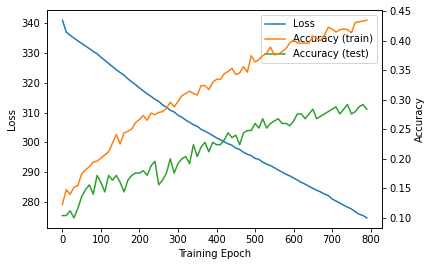

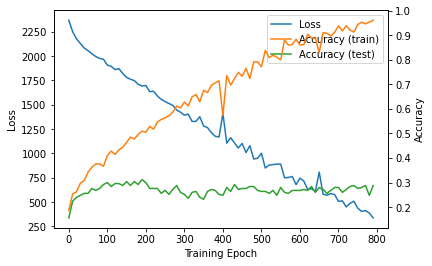

In [ ]:
### CLASSIFY CIFAR10 PICTURES SUM OF SQUARES VS CROSS ENTROPY COST FUNCTION
## SIGMOID ACTIVATION AND NORMAL WEIGHT INITIALIZATION (k=1)

# create a dataset of 1000 CIFAR-10 images, reshaped as single vectors, and labels
data = cifar10.load_data()

X = data[0][0][:1000].reshape([1000,32*32*3])
Y = data[0][1][:1000]

# randomly choose 75% of the data to be the training set and 25% for the testing set
(trainX, testX, trainY, testY) = train_test_split(X, Y, test_size = 0.25, random_state = 1)

# normalize the data
trainX = normalize(trainX)
testX = normalize(testX)

# fit the model to the training data 
print("\n***** Sum of squares *****")
model = FeedforwardNeuralNetwork([3072, 32, 16, 10], 0.01, 0, 0, 32, 0, ['normal', 1], 'sigmoid', 'sum-of-squares')
model.fit(trainX, trainY, testX, testY, 800, 10)

print("Training set accuracy")
trainY = LabelBinarizer().fit_transform(trainY)
predictedY = model.predict(trainX)
predictedY = predictedY.argmax(axis=1)
trainY = trainY.argmax(axis=1)
print(accuracy_score(trainY, predictedY))

print("Test set accuracy")
testY = LabelBinarizer().fit_transform(testY)
predictedY = model.predict(testX)
predictedY = predictedY.argmax(axis=1)
testY = testY.argmax(axis=1)
print(accuracy_score(testY, predictedY))

print("\n***** Cross Entropy *****")
# fit the model to the training data
model = FeedforwardNeuralNetwork([3072, 32, 16, 10], 0.01, 0, 0, 32, 0, ['normal', 1], 'sigmoid', 'cross-entropy')
model.fit(trainX, trainY, testX, testY, 800, 10)

print("Training set accuracy")
trainY = LabelBinarizer().fit_transform(trainY)
predictedY = model.predict(trainX)
predictedY = predictedY.argmax(axis=1)
trainY = trainY.argmax(axis=1)
print(accuracy_score(trainY, predictedY))

print("Test set accuracy")
testY = LabelBinarizer().fit_transform(testY)
predictedY = model.predict(testX)
predictedY = predictedY.argmax(axis=1)
testY = testY.argmax(axis=1)
print(accuracy_score(testY, predictedY))

Both loss functions resulted in a similar testing accuracy but the cross-entropy loss function learned much faster. Looking at the figures, you can see that the testing accuracy does not really improve much after about 100-200 epochs with the cross entropy loss function. With the sum of squares loss function, we see very small improvements continuing through all 800 epochs. Recall that gamma is a hyperparameter used for momentum, which canhelp speed up learning as well. Testing the sum of squares and cross entropy loss functions with different gamma values.

In [ ]:
### CLASSIFY CIFAR10 PICTURES SUM OF SQUARES VS CROSS ENTROPY COST FUNCTION
## SIGMOID ACTIVATION AND NORMAL WEIGHT INITIALIZATION (k=1)

# create a dataset of 1000 CIFAR-10 images, reshaped as single vectors, and labels
data = cifar10.load_data()

X = data[0][0][:1000].reshape([1000,32*32*3])
Y = data[0][1][:1000]

# randomly choose 75% of the data to be the training set and 25% for the testing set
(trainX, testX, trainY, testY) = train_test_split(X, Y, test_size = 0.25, random_state = 1)

# normalize the data
trainX = normalize(trainX)
testX = normalize(testX)

list = [0.0, 0.2, 0.5, 0.7, 0.9]
for gamma in list:
  # fit the model to the training data
  print("\n***** Sum of squares, gamma =", gamma)
  model = FeedforwardNeuralNetwork([3072, 32, 16, 10], 0.01, 0, 0, 32, gamma, ['normal', 1], 'sigmoid', 'sum-of-squares')
  model.fit(trainX, trainY, testX, testY, 500, 10, printPerformance=False)

  print("Training set accuracy")
  trainY = LabelBinarizer().fit_transform(trainY)
  predictedY = model.predict(trainX)
  predictedY = predictedY.argmax(axis=1)
  trainY = trainY.argmax(axis=1)
  print(accuracy_score(trainY, predictedY))

  print("Test set accuracy")
  testY = LabelBinarizer().fit_transform(testY)
  predictedY = model.predict(testX)
  predictedY = predictedY.argmax(axis=1)
  testY = testY.argmax(axis=1)
  print(accuracy_score(testY, predictedY))

  print("\n***** Cross Entropy, gamma=", gamma)
  # fit the model to the training data
  model = FeedforwardNeuralNetwork([3072, 32, 16, 10], 0.01, 0, 0, 32, gamma, ['normal', 1], 'sigmoid', 'cross-entropy')
  model.fit(trainX, trainY, testX, testY, 500, 10, printPerformance = False)

  print("Training set accuracy")
  trainY = LabelBinarizer().fit_transform(trainY)
  predictedY = model.predict(trainX)
  predictedY = predictedY.argmax(axis=1)
  trainY = trainY.argmax(axis=1)
  print(accuracy_score(trainY, predictedY))

  print("Test set accuracy")
  testY = LabelBinarizer().fit_transform(testY)
  predictedY = model.predict(testX)
  predictedY = predictedY.argmax(axis=1)
  testY = testY.argmax(axis=1)
  print(accuracy_score(testY, predictedY))


***** Sum of squares, gamma = 0.0
Training set accuracy
0.32266666666666666
Test set accuracy
0.252

***** Cross Entropy, gamma= 0.0
Training set accuracy
0.7746666666666666
Test set accuracy
0.288

***** Sum of squares, gamma = 0.2
Training set accuracy
0.376
Test set accuracy
0.22

***** Cross Entropy, gamma= 0.2
Training set accuracy
0.82
Test set accuracy
0.264

***** Sum of squares, gamma = 0.5
Training set accuracy
0.44266666666666665
Test set accuracy
0.276

***** Cross Entropy, gamma= 0.5
Training set accuracy
0.964
Test set accuracy
0.312

***** Sum of squares, gamma = 0.7
Training set accuracy
0.536
Test set accuracy
0.28

***** Cross Entropy, gamma= 0.7
Training set accuracy
0.996
Test set accuracy
0.256

***** Sum of squares, gamma = 0.9
Training set accuracy
0.8026666666666666
Test set accuracy
0.272

***** Cross Entropy, gamma= 0.9
Training set accuracy
1.0
Test set accuracy
0.324


It is clear to see that gamma can have a large effect on the accuracy of the model using either of the two loss functions. Based on the results, using the cross entropy loss function with gamma > 0.5 provides a better testing accuracy. Let's see if we can find an even better gamma for the corss-entropy loss function by testing values between 0.5 and 0.95

In [ ]:
### CLASSIFY CIFAR10 PICTURES SUM OF SQUARES VS CROSS ENTROPY COST FUNCTION
## SIGMOID ACTIVATION AND NORMAL WEIGHT INITIALIZATION (k=1)

# create a dataset of 1000 CIFAR-10 images, reshaped as single vectors, and labels
data = cifar10.load_data()

X = data[0][0][:1000].reshape([1000,32*32*3])
Y = data[0][1][:1000]

# randomly choose 75% of the data to be the training set and 25% for the testing set
(trainX, testX, trainY, testY) = train_test_split(X, Y, test_size = 0.25, random_state = 1)

# normalize the data
trainX = normalize(trainX)
testX = normalize(testX)

list = [0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
for gamma in list:
  print("\n***** Cross Entropy, gamma=", gamma)
  # fit the model to the training data
  model = FeedforwardNeuralNetwork([3072, 32, 16, 10], 0.01, 0, 0, 32, gamma, ['normal', 1], 'sigmoid', 'cross-entropy')
  model.fit(trainX, trainY, testX, testY, 300, 10, printPerformance=False)

  print("Training set accuracy")
  trainY = LabelBinarizer().fit_transform(trainY)
  predictedY = model.predict(trainX)
  predictedY = predictedY.argmax(axis=1)
  trainY = trainY.argmax(axis=1)
  print(accuracy_score(trainY, predictedY))

  print("Test set accuracy")
  testY = LabelBinarizer().fit_transform(testY)
  predictedY = model.predict(testX)
  predictedY = predictedY.argmax(axis=1)
  testY = testY.argmax(axis=1)
  print(accuracy_score(testY, predictedY))


***** Cross Entropy, gamma= 0.4
Training set accuracy
0.768
Test set accuracy
0.28

***** Cross Entropy, gamma= 0.5
Training set accuracy
0.7986666666666666
Test set accuracy
0.276

***** Cross Entropy, gamma= 0.6
Training set accuracy
0.8506666666666667
Test set accuracy
0.308

***** Cross Entropy, gamma= 0.7
Training set accuracy
0.8173333333333334
Test set accuracy
0.252

***** Cross Entropy, gamma= 0.8
Training set accuracy
0.8906666666666667
Test set accuracy
0.296

***** Cross Entropy, gamma= 0.9
Training set accuracy
0.968
Test set accuracy
0.24


bringing up gamma too high results in a lower accuracy so, we will choose gamma = 0.7
##Regularization
First we want to address the problem of overfitting. We can use L1 and L2 regularization to prevent the weights from getting very large. This will bring our training accuracy down but in turn, the testing accuracy will see improvements. Since I am not sure what L1 and L2 values will work best, first I'll try the following values for L1: [0.01, 0.1, 1, 5, 10]

In [ ]:
### CLASSIFY CIRFAR-10 PICTURES WITH L2 PENALTY
## ALPHA = 0.01
## CROSS ENTROPY LOSS FUNCTION

# create a dataset of 1000 CIFAR-10 images, reshaped as single vectors, and labels
data = cifar10.load_data()

X = data[0][0][:1000].reshape([1000,32*32*3])
Y = data[0][1][:1000]

# randomly choose 75% of the data to be the training set and 25% for the testing set
(trainX, testX, trainY, testY) = train_test_split(X, Y, test_size = 0.25, random_state=1)

# normalize the data
trainX = normalize(trainX)
testX = normalize(testX)

list = [0.01, 0.1, 1, 5, 10]
best_accuracy = {"L1": 0.0, "L2": 0.0, "acc":0.0}
for lmbda1 in list: 
  print("\n*****Normal, k= 1, L1 =", lmbda1, "L2 = 0", )
  # fit the model to the training data
  model = FeedforwardNeuralNetwork([3072, 32, 16, 10], 0.01, lmbda1, 0.0, 32, 0.6, ['normal', 1], 'sigmoid', 'sum-of-squares')
  model.fit(trainX, trainY, testX, testY, 500, 10, printPerformance = False)

  print("Training set accuracy")
  trainY = LabelBinarizer().fit_transform(trainY)
  predictedY = model.predict(trainX)
  predictedY = predictedY.argmax(axis=1)
  trainY = trainY.argmax(axis=1)
  print(accuracy_score(trainY, predictedY))

  print("Test set accuracy")
  testY = LabelBinarizer().fit_transform(testY)
  predictedY = model.predict(testX)
  predictedY = predictedY.argmax(axis=1)
  testY = testY.argmax(axis=1)
  accuracy = accuracy_score(testY, predictedY)
  print(accuracy)
  if accuracy > best_accuracy["acc"]:
    best_accuracy["L1"] = lmbda1
    #best_accuracy["L2"] = lmbda2
    best_accuracy["acc"] = accuracy

print(best_accuracy)



*****Normal, k= 1, L1 = 0.01 L2 = 0
Training set accuracy
0.54
Test set accuracy
0.268

*****Normal, k= 1, L1 = 0.1 L2 = 0
Training set accuracy
0.49866666666666665
Test set accuracy
0.264

*****Normal, k= 1, L1 = 1 L2 = 0
Training set accuracy
0.48133333333333334
Test set accuracy
0.292

*****Normal, k= 1, L1 = 5 L2 = 0
Training set accuracy
0.19866666666666666
Test set accuracy
0.144

*****Normal, k= 1, L1 = 10 L2 = 0
Training set accuracy
0.112
Test set accuracy
0.112
{'L1': 1, 'L2': 0.0, 'acc': 0.292}


Now testing for an L2 value


*****Normal, k= 1, L1 = 0 L2 = 0.01
Training set accuracy
0.772
Test set accuracy
0.284

*****Normal, k= 1, L1 = 0 L2 = 0.1
Training set accuracy
0.6853333333333333
Test set accuracy
0.28

*****Normal, k= 1, L1 = 0 L2 = 1
Training set accuracy
0.588
Test set accuracy
0.28

*****Normal, k= 1, L1 = 0 L2 = 5
Training set accuracy
0.6733333333333333
Test set accuracy
0.276

*****Normal, k= 1, L1 = 0 L2 = 10
Training set accuracy
0.5453333333333333
Test set accuracy
0.3

*****Normal, k= 1, L1 = 0 L2 = 50
Training set accuracy
0.21333333333333335
Test set accuracy
0.14
{'L1': 0.0, 'L2': 10, 'acc': 0.3}


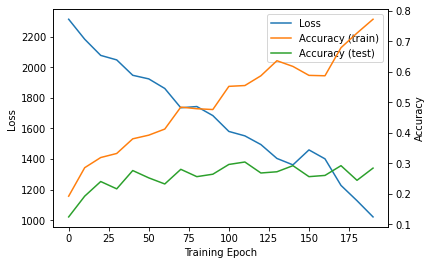

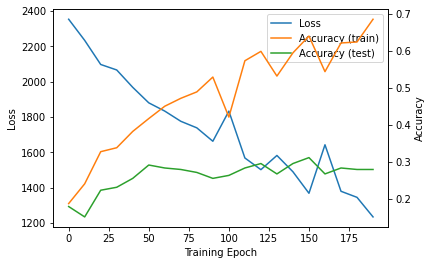

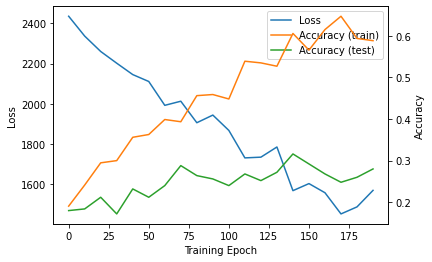

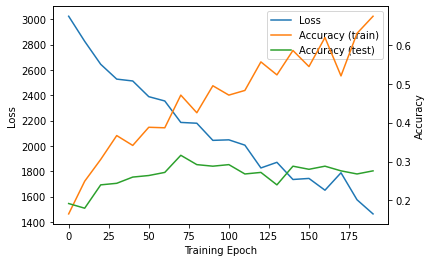

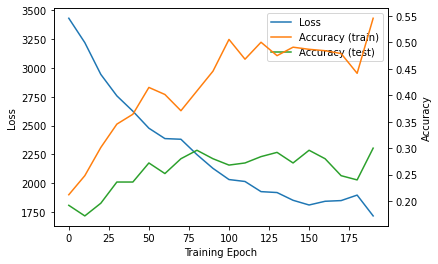

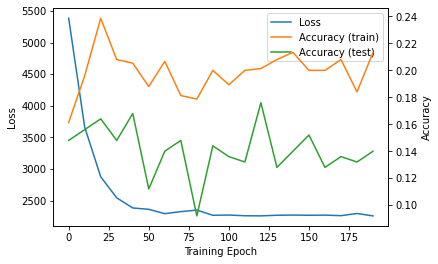

In [ ]:
### CLASSIFY CIRFAR-10 PICTURES WITH L2 PENALTY
## ALPHA = 0.01
## CROSS ENTROPY LOSS FUNCTION

# create a dataset of 1000 CIFAR-10 images, reshaped as single vectors, and labels
data = cifar10.load_data()

X = data[0][0][:1000].reshape([1000,32*32*3])
Y = data[0][1][:1000]

# randomly choose 75% of the data to be the training set and 25% for the testing set
(trainX, testX, trainY, testY) = train_test_split(X, Y, test_size = 0.25, random_state=1)

# normalize the data
trainX = normalize(trainX)
testX = normalize(testX)

list = [0.01, 0.1, 1, 5, 10, 50]
best_accuracy = {"L1": 0.0, "L2": 0.0, "acc":0.0}
for lmbda2 in list: 
  print("\n*****Normal, k= 1, L1 = 0", "L2 =", lmbda2 )
  # fit the model to the training data
  model = FeedforwardNeuralNetwork([3072, 32, 16, 10], 0.01, 0.0, lmbda2, 32, 0.6, ['normal', 1], 'sigmoid', 'cross-entropy')
  model.fit(trainX, trainY, testX, testY, 200, 10)

  print("Training set accuracy")
  trainY = LabelBinarizer().fit_transform(trainY)
  predictedY = model.predict(trainX)
  predictedY = predictedY.argmax(axis=1)
  trainY = trainY.argmax(axis=1)
  print(accuracy_score(trainY, predictedY))

  print("Test set accuracy")
  testY = LabelBinarizer().fit_transform(testY)
  predictedY = model.predict(testX)
  predictedY = predictedY.argmax(axis=1)
  testY = testY.argmax(axis=1)
  accuracy = accuracy_score(testY, predictedY)
  print(accuracy)
  if accuracy > best_accuracy["acc"]:
    #best_accuracy["L1"] = lmbda1
    best_accuracy["L2"] = lmbda2
    best_accuracy["acc"] = accuracy


print(best_accuracy)


Lookig at the figures we can see that a very high L2 value performs poorly and a value of 5 performs well. Taking our best L1 and L2, we can vary the learning the learning rate to see the impact


*****Normal, k= 1, L1 = 1, L2=5, alpha=  0.001
Training set accuracy
0.32666666666666666
Test set accuracy
0.22

*****Normal, k= 1, L1 = 1, L2=5, alpha=  0.005
Training set accuracy
0.492
Test set accuracy
0.284

*****Normal, k= 1, L1 = 1, L2=5, alpha=  0.01
Training set accuracy
0.392
Test set accuracy
0.244

*****Normal, k= 1, L1 = 1, L2=5, alpha=  0.1
Training set accuracy
0.10533333333333333
Test set accuracy
0.112


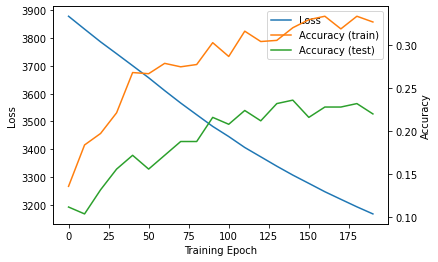

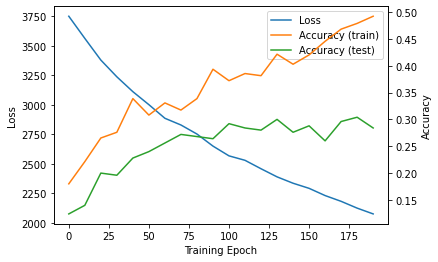

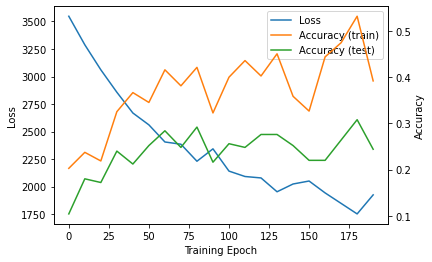

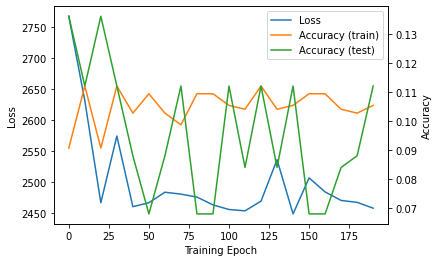

In [ ]:
### CLASSIFY CIRFAR-10 PICTURES WITH VARYING ALPHA
## CROSS ENTROPY LOSS FUNCTION

# create a dataset of 1000 CIFAR-10 images, reshaped as single vectors, and labels
data = cifar10.load_data()

X = data[0][0][:1000].reshape([1000,32*32*3])
Y = data[0][1][:1000]

# randomly choose 75% of the data to be the training set and 25% for the testing set
(trainX, testX, trainY, testY) = train_test_split(X, Y, test_size = 0.25, random_state = 1)

# normalize the data
trainX = normalize(trainX)
testX = normalize(testX)

list = [0.001, 0.005, 0.01, 0.1]
for alpha in list:
  print("\n*****Normal, k= 1, L1 = 1, L2=5, alpha= ", alpha)
  # fit the model to the training data
  model = FeedforwardNeuralNetwork([3072, 32, 16, 10], alpha, 1.0, 10.0, 32, 0.6, ['normal', 1], 'sigmoid', 'cross-entropy')
  model.fit(trainX, trainY, testX, testY, 200, 10)

  print("Training set accuracy")
  trainY = LabelBinarizer().fit_transform(trainY)
  predictedY = model.predict(trainX)
  predictedY = predictedY.argmax(axis=1)
  trainY = trainY.argmax(axis=1)
  print(accuracy_score(trainY, predictedY))

  print("Test set accuracy")
  testY = LabelBinarizer().fit_transform(testY)
  predictedY = model.predict(testX)
  predictedY = predictedY.argmax(axis=1)
  testY = testY.argmax(axis=1)
  print(accuracy_score(testY, predictedY))


A large learning rate does not work well because the model is not learning. A small learning rate, of 0.01 or 0.005 seems to work best with the data

## Weight Initialization
Testing different weight initialization methods including normal with k =1 , uniform from -0.2, 0.2, He Normal, and He Uniform. Increasing the number of epochs to get a full picture of how each is performing.


*****Normal, k=1
Training set accuracy
0.5093333333333333
Test set accuracy
0.284

*****Uniform, (-0.2, 0.2)
Training set accuracy
0.10933333333333334
Test set accuracy
0.068

*****LeCun, normal
Training set accuracy
0.22
Test set accuracy
0.144

*****LeCun, uniform
Training set accuracy
0.21466666666666667
Test set accuracy
0.12

*****He, normal
Training set accuracy
0.284
Test set accuracy
0.216

*****He, uniform
Training set accuracy
0.288
Test set accuracy
0.204


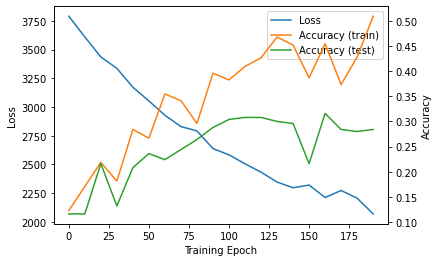

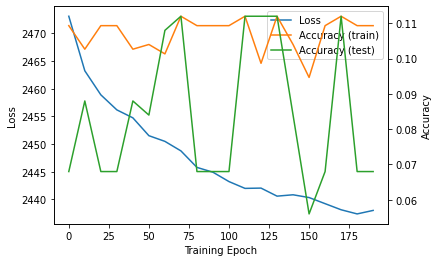

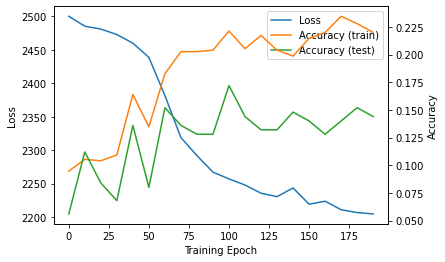

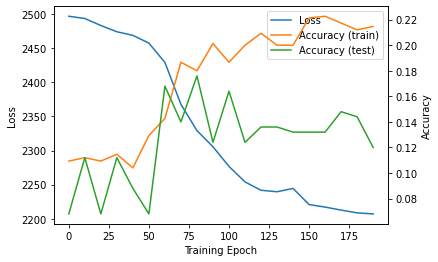

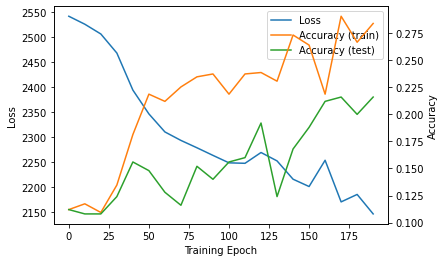

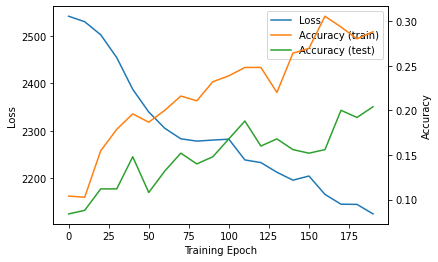

In [ ]:
### CLASSIFY cifar10 PICTURES WITH DIFF WEIGHT INITIALIZATIONS 
## ALPHA = 0.005
## CROSS ENTROPY LOSS FUNCTION

# create a dataset of 1000 CIFAR-10 images, reshaped as single vectors, and labels
data = cifar10.load_data()

X = data[0][0][:1000].reshape([1000,32*32*3])
Y = data[0][1][:1000]

# randomly choose 75% of the data to be the training set and 25% for the testing set
(trainX, testX, trainY, testY) = train_test_split(X, Y, test_size = 0.25, random_state=1)

# normalize the data
trainX = normalize(trainX)
testX = normalize(testX)

print("\n*****Normal, k=1")
# fit the model to the training data
model = FeedforwardNeuralNetwork([3072, 32, 16, 10], 0.005, 1.0, 10.0, 32, 0.6, ['normal', 1], 'sigmoid', 'cross-entropy')
model.fit(trainX, trainY, testX, testY, 200, 10)

print("Training set accuracy")
trainY = LabelBinarizer().fit_transform(trainY)
predictedY = model.predict(trainX)
predictedY = predictedY.argmax(axis=1)
trainY = trainY.argmax(axis=1)
print(accuracy_score(trainY, predictedY))

print("Test set accuracy")
testY = LabelBinarizer().fit_transform(testY)
predictedY = model.predict(testX)
predictedY = predictedY.argmax(axis=1)
testY = testY.argmax(axis=1)
print(accuracy_score(testY, predictedY))

print("\n*****Uniform, (-0.2, 0.2)")
# fit the model to the training data
model = FeedforwardNeuralNetwork([3072, 32, 16, 10], 0.005, 1.0, 10.0, 32, 0.6, ['uniform', -0.2, 0.2], 'sigmoid', 'cross-entropy')
model.fit(trainX, trainY, testX, testY, 200, 10)

print("Training set accuracy")
trainY = LabelBinarizer().fit_transform(trainY)
predictedY = model.predict(trainX)
predictedY = predictedY.argmax(axis=1)
trainY = trainY.argmax(axis=1)
print(accuracy_score(trainY, predictedY))

print("Test set accuracy")
testY = LabelBinarizer().fit_transform(testY)
predictedY = model.predict(testX)
predictedY = predictedY.argmax(axis=1)
testY = testY.argmax(axis=1)
print(accuracy_score(testY, predictedY))

print("\n*****LeCun, normal")
# fit the model to the training data
model = FeedforwardNeuralNetwork([3072, 32, 16, 10], 0.005, 1.0, 10.0, 32, 0.6, ['LeCun', 'normal'], 'sigmoid', 'cross-entropy')
model.fit(trainX, trainY, testX, testY, 200, 10)

print("Training set accuracy")
trainY = LabelBinarizer().fit_transform(trainY)
predictedY = model.predict(trainX)
predictedY = predictedY.argmax(axis=1)
trainY = trainY.argmax(axis=1)
print(accuracy_score(trainY, predictedY))

print("Test set accuracy")
testY = LabelBinarizer().fit_transform(testY)
predictedY = model.predict(testX)
predictedY = predictedY.argmax(axis=1)
testY = testY.argmax(axis=1)
print(accuracy_score(testY, predictedY))

print("\n*****LeCun, uniform")
# fit the model to the training data
model = FeedforwardNeuralNetwork([3072, 32, 16, 10], 0.005, 1.0, 10.0, 32, 0.6, ['LeCun', 'uniform'], 'sigmoid', 'cross-entropy')
model.fit(trainX, trainY, testX, testY, 200, 10)

print("Training set accuracy")
trainY = LabelBinarizer().fit_transform(trainY)
predictedY = model.predict(trainX)
predictedY = predictedY.argmax(axis=1)
trainY = trainY.argmax(axis=1)
print(accuracy_score(trainY, predictedY))

print("Test set accuracy")
testY = LabelBinarizer().fit_transform(testY)
predictedY = model.predict(testX)
predictedY = predictedY.argmax(axis=1)
testY = testY.argmax(axis=1)
print(accuracy_score(testY, predictedY))

print("\n*****He, normal")
# fit the model to the training data
model = FeedforwardNeuralNetwork([3072, 32, 16, 10], 0.005, 1.0, 10.0, 32, 0.6, ['He', 'normal'], 'sigmoid', 'cross-entropy')
model.fit(trainX, trainY, testX, testY, 200, 10)

print("Training set accuracy")
trainY = LabelBinarizer().fit_transform(trainY)
predictedY = model.predict(trainX)
predictedY = predictedY.argmax(axis=1)
trainY = trainY.argmax(axis=1)
print(accuracy_score(trainY, predictedY))

print("Test set accuracy")
testY = LabelBinarizer().fit_transform(testY)
predictedY = model.predict(testX)
predictedY = predictedY.argmax(axis=1)
testY = testY.argmax(axis=1)
print(accuracy_score(testY, predictedY))

print("\n*****He, uniform")
# fit the model to the training data
model = FeedforwardNeuralNetwork([3072, 32, 16, 10], 0.005, 1.0, 10.0, 32, 0.6, ['He', 'uniform'], 'sigmoid', 'cross-entropy')
model.fit(trainX, trainY, testX, testY, 200, 10)

print("Training set accuracy")
trainY = LabelBinarizer().fit_transform(trainY)
predictedY = model.predict(trainX)
predictedY = predictedY.argmax(axis=1)
trainY = trainY.argmax(axis=1)
print(accuracy_score(trainY, predictedY))

print("Test set accuracy")
testY = LabelBinarizer().fit_transform(testY)
predictedY = model.predict(testX)
predictedY = predictedY.argmax(axis=1)
testY = testY.argmax(axis=1)
print(accuracy_score(testY, predictedY))


Uniform performed very poorly on -0.1, 0.1 so we will increase it to -0.2, 0.2 and see the result. 


*****Normal, k=1
Training set accuracy
0.568
Test set accuracy
0.304

*****Uniform, (-0.2, 0.2)
Training set accuracy
0.3426666666666667
Test set accuracy
0.232

*****LeCun, normal
Training set accuracy
0.224
Test set accuracy
0.144

*****LeCun, uniform
Training set accuracy
0.23466666666666666
Test set accuracy
0.14

*****He, normal
Training set accuracy
0.3466666666666667
Test set accuracy
0.212

*****He, uniform
Training set accuracy
0.4013333333333333
Test set accuracy
0.22


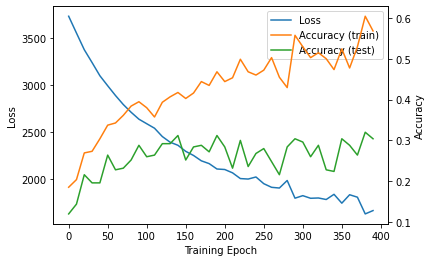

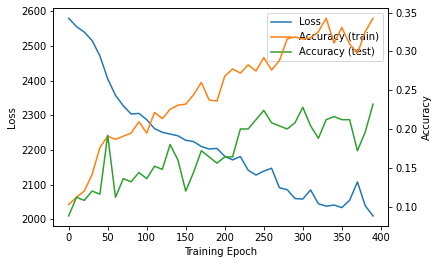

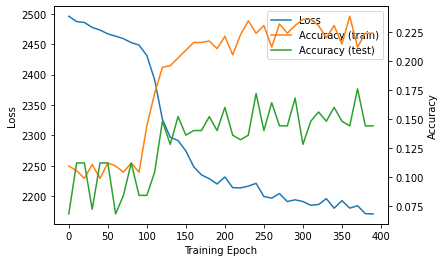

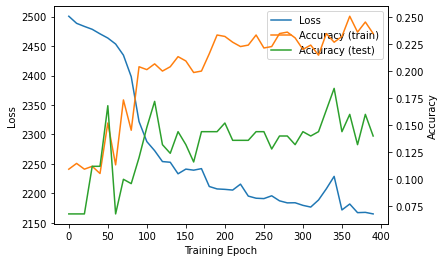

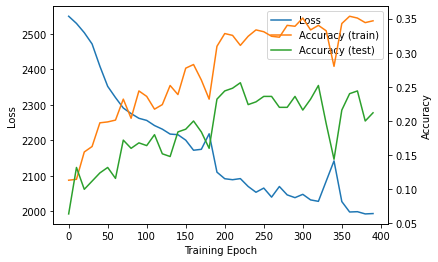

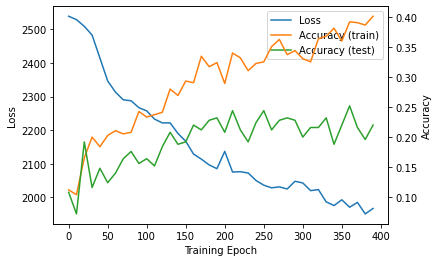

In [ ]:
### CLASSIFY cifar10 PICTURES WITH DIFF WEIGHT INITIALIZATIONS 
## ALPHA = 0.005
## CROSS ENTROPY LOSS FUNCTION

# create a dataset of 1000 CIFAR-10 images, reshaped as single vectors, and labels
data = cifar10.load_data()

X = data[0][0][:1000].reshape([1000,32*32*3])
Y = data[0][1][:1000]

# randomly choose 75% of the data to be the training set and 25% for the testing set
(trainX, testX, trainY, testY) = train_test_split(X, Y, test_size = 0.25, random_state=1)

# normalize the data
trainX = normalize(trainX)
testX = normalize(testX)

print("\n*****Normal, k=1")
# fit the model to the training data
model = FeedforwardNeuralNetwork([3072, 32, 16, 10], 0.005, 1.0, 10.0, 32, 0.6, ['normal', 1], 'sigmoid', 'cross-entropy')
model.fit(trainX, trainY, testX, testY, 400, 10)

print("Training set accuracy")
trainY = LabelBinarizer().fit_transform(trainY)
predictedY = model.predict(trainX)
predictedY = predictedY.argmax(axis=1)
trainY = trainY.argmax(axis=1)
print(accuracy_score(trainY, predictedY))

print("Test set accuracy")
testY = LabelBinarizer().fit_transform(testY)
predictedY = model.predict(testX)
predictedY = predictedY.argmax(axis=1)
testY = testY.argmax(axis=1)
print(accuracy_score(testY, predictedY))

print("\n*****Uniform, (-0.2, 0.2)")
# fit the model to the training data
model = FeedforwardNeuralNetwork([3072, 32, 16, 10], 0.005, 1.0, 10.0, 32, 0.6, ['uniform', -0.5, 0.5], 'sigmoid', 'cross-entropy')
model.fit(trainX, trainY, testX, testY, 400, 10)

print("Training set accuracy")
trainY = LabelBinarizer().fit_transform(trainY)
predictedY = model.predict(trainX)
predictedY = predictedY.argmax(axis=1)
trainY = trainY.argmax(axis=1)
print(accuracy_score(trainY, predictedY))

print("Test set accuracy")
testY = LabelBinarizer().fit_transform(testY)
predictedY = model.predict(testX)
predictedY = predictedY.argmax(axis=1)
testY = testY.argmax(axis=1)
print(accuracy_score(testY, predictedY))

print("\n*****LeCun, normal")
# fit the model to the training data
model = FeedforwardNeuralNetwork([3072, 32, 16, 10], 0.005, 1.0, 10.0, 32, 0.6, ['LeCun', 'normal'], 'sigmoid', 'cross-entropy')
model.fit(trainX, trainY, testX, testY, 400, 10)

print("Training set accuracy")
trainY = LabelBinarizer().fit_transform(trainY)
predictedY = model.predict(trainX)
predictedY = predictedY.argmax(axis=1)
trainY = trainY.argmax(axis=1)
print(accuracy_score(trainY, predictedY))

print("Test set accuracy")
testY = LabelBinarizer().fit_transform(testY)
predictedY = model.predict(testX)
predictedY = predictedY.argmax(axis=1)
testY = testY.argmax(axis=1)
print(accuracy_score(testY, predictedY))

print("\n*****LeCun, uniform")
# fit the model to the training data
model = FeedforwardNeuralNetwork([3072, 32, 16, 10], 0.005, 1.0, 10.0, 32, 0.6, ['LeCun', 'uniform'], 'sigmoid', 'cross-entropy')
model.fit(trainX, trainY, testX, testY, 400, 10)

print("Training set accuracy")
trainY = LabelBinarizer().fit_transform(trainY)
predictedY = model.predict(trainX)
predictedY = predictedY.argmax(axis=1)
trainY = trainY.argmax(axis=1)
print(accuracy_score(trainY, predictedY))

print("Test set accuracy")
testY = LabelBinarizer().fit_transform(testY)
predictedY = model.predict(testX)
predictedY = predictedY.argmax(axis=1)
testY = testY.argmax(axis=1)
print(accuracy_score(testY, predictedY))

print("\n*****He, normal")
# fit the model to the training data
model = FeedforwardNeuralNetwork([3072, 32, 16, 10], 0.005, 1.0, 10.0, 32, 0.6, ['He', 'normal'], 'sigmoid', 'cross-entropy')
model.fit(trainX, trainY, testX, testY, 400, 10)

print("Training set accuracy")
trainY = LabelBinarizer().fit_transform(trainY)
predictedY = model.predict(trainX)
predictedY = predictedY.argmax(axis=1)
trainY = trainY.argmax(axis=1)
print(accuracy_score(trainY, predictedY))

print("Test set accuracy")
testY = LabelBinarizer().fit_transform(testY)
predictedY = model.predict(testX)
predictedY = predictedY.argmax(axis=1)
testY = testY.argmax(axis=1)
print(accuracy_score(testY, predictedY))

print("\n*****He, uniform")
# fit the model to the training data
model = FeedforwardNeuralNetwork([3072, 32, 16, 10], 0.005, 1.0, 10.0, 32, 0.6, ['He', 'uniform'], 'sigmoid', 'cross-entropy')
model.fit(trainX, trainY, testX, testY, 400, 10)

print("Training set accuracy")
trainY = LabelBinarizer().fit_transform(trainY)
predictedY = model.predict(trainX)
predictedY = predictedY.argmax(axis=1)
trainY = trainY.argmax(axis=1)
print(accuracy_score(trainY, predictedY))

print("Test set accuracy")
testY = LabelBinarizer().fit_transform(testY)
predictedY = model.predict(testX)
predictedY = predictedY.argmax(axis=1)
testY = testY.argmax(axis=1)
print(accuracy_score(testY, predictedY))


A normal weight initialization is working better than th others so I am going to stick with that

## Architecture



***** 2 hidden layers
Training set accuracy
0.46266666666666667
Test set accuracy
0.28

*****3 hidden layers
Training set accuracy
0.4573333333333333
Test set accuracy
0.26

***** 3 hidden layers-first is large
Training set accuracy
0.424
Test set accuracy
0.24


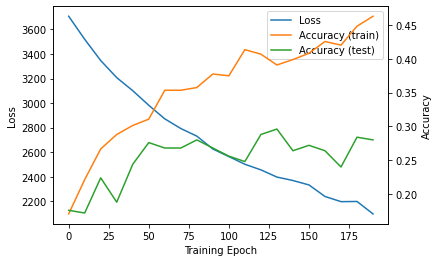

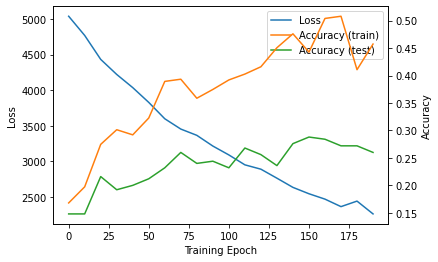

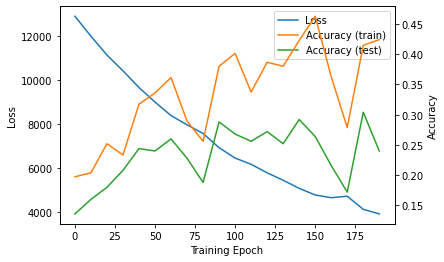

In [ ]:
### CLASSIFY cifar10 PICTURES WITH DIFF WEIGHT INITIALIZATIONS 
## ALPHA = 0.005
## CROSS ENTROPY LOSS FUNCTION

# create a dataset of 1000 CIFAR-10 images, reshaped as single vectors, and labels
data = cifar10.load_data()

X = data[0][0][:1000].reshape([1000,32*32*3])
Y = data[0][1][:1000]

# randomly choose 75% of the data to be the training set and 25% for the testing set
(trainX, testX, trainY, testY) = train_test_split(X, Y, test_size = 0.25, random_state=1)

# normalize the data
trainX = normalize(trainX)
testX = normalize(testX)

print("\n***** 2 hidden layers")
# fit the model to the training data
model = FeedforwardNeuralNetwork([3072, 32, 16, 10], 0.005, 1.0, 10.0, 32, 0.6, ['normal', 1], 'sigmoid', 'cross-entropy')
model.fit(trainX, trainY, testX, testY, 200, 10)

print("Training set accuracy")
trainY = LabelBinarizer().fit_transform(trainY)
predictedY = model.predict(trainX)
predictedY = predictedY.argmax(axis=1)
trainY = trainY.argmax(axis=1)
print(accuracy_score(trainY, predictedY))

print("Test set accuracy")
testY = LabelBinarizer().fit_transform(testY)
predictedY = model.predict(testX)
predictedY = predictedY.argmax(axis=1)
testY = testY.argmax(axis=1)
print(accuracy_score(testY, predictedY))

print("\n*****3 hidden layers")
# fit the model to the training data
model = FeedforwardNeuralNetwork([3072, 64, 32, 16, 10], 0.005, 1.0, 10.0, 32, 0.6, ['normal', 1], 'sigmoid', 'cross-entropy')
model.fit(trainX, trainY, testX, testY, 200, 10)

print("Training set accuracy")
trainY = LabelBinarizer().fit_transform(trainY)
predictedY = model.predict(trainX)
predictedY = predictedY.argmax(axis=1)
trainY = trainY.argmax(axis=1)
print(accuracy_score(trainY, predictedY))

print("Test set accuracy")
testY = LabelBinarizer().fit_transform(testY)
predictedY = model.predict(testX)
predictedY = predictedY.argmax(axis=1)
testY = testY.argmax(axis=1)
print(accuracy_score(testY, predictedY))

print("\n***** 3 hidden layers-first is large")
# fit the model to the training data
model = FeedforwardNeuralNetwork([3072, 256, 32, 16, 10], 0.005, 1.0, 10.0, 32, 0.6, ['normal', 1], 'sigmoid', 'cross-entropy')
model.fit(trainX, trainY, testX, testY, 200, 10)

print("Training set accuracy")
trainY = LabelBinarizer().fit_transform(trainY)
predictedY = model.predict(trainX)
predictedY = predictedY.argmax(axis=1)
trainY = trainY.argmax(axis=1)
print(accuracy_score(trainY, predictedY))

print("Test set accuracy")
testY = LabelBinarizer().fit_transform(testY)
predictedY = model.predict(testX)
predictedY = predictedY.argmax(axis=1)
testY = testY.argmax(axis=1)
print(accuracy_score(testY, predictedY))

Trying some more combinations...


170500096/170498071 [==============================] - 6s 0us/step

***** layers: [3072, 512, 32, 10]
Training set accuracy
0.496
Test set accuracy
0.292

***** layers: [3072, 512, 16, 10]
Training set accuracy
0.304
Test set accuracy
0.2

***** layers: [3072, 256, 32, 10]
Training set accuracy
0.5506666666666666
Test set accuracy
0.304

***** layers: [3072, 256, 16, 10]
Training set accuracy
0.43066666666666664
Test set accuracy
0.276

***** layers: [3072, 64, 16, 10]
Training set accuracy
0.464
Test set accuracy
0.288


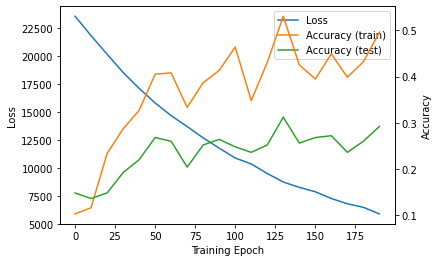

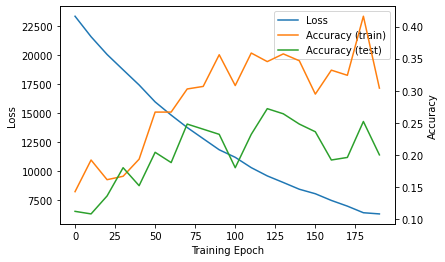

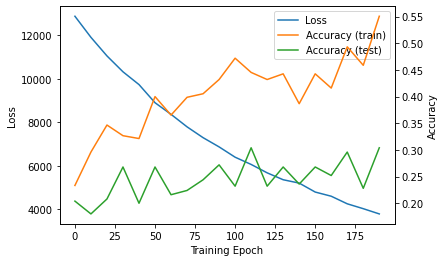

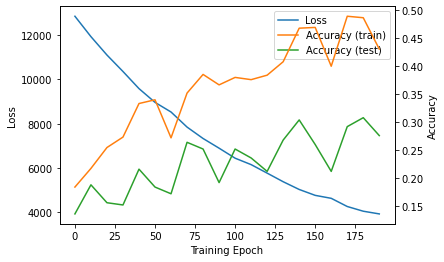

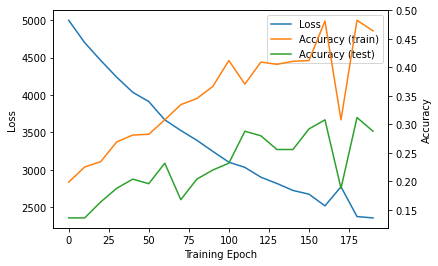

In [ ]:
### CLASSIFY cifar10 PICTURES WITH DIFF WEIGHT INITIALIZATIONS 
## ALPHA = 0.005
## CROSS ENTROPY LOSS FUNCTION

# create a dataset of 1000 CIFAR-10 images, reshaped as single vectors, and labels
data = cifar10.load_data()

X = data[0][0][:1000].reshape([1000,32*32*3])
Y = data[0][1][:1000]

# randomly choose 75% of the data to be the training set and 25% for the testing set
(trainX, testX, trainY, testY) = train_test_split(X, Y, test_size = 0.25, random_state=1)

# normalize the data
trainX = normalize(trainX)
testX = normalize(testX)

print("\n***** layers: [3072, 512, 32, 10]")
# fit the model to the training data
model = FeedforwardNeuralNetwork([3072, 512, 32, 10], 0.005, 1.0, 10.0, 32, 0.6, ['normal', 1], 'sigmoid', 'cross-entropy')
model.fit(trainX, trainY, testX, testY, 200, 10)

print("Training set accuracy")
trainY = LabelBinarizer().fit_transform(trainY)
predictedY = model.predict(trainX)
predictedY = predictedY.argmax(axis=1)
trainY = trainY.argmax(axis=1)
print(accuracy_score(trainY, predictedY))

print("Test set accuracy")
testY = LabelBinarizer().fit_transform(testY)
predictedY = model.predict(testX)
predictedY = predictedY.argmax(axis=1)
testY = testY.argmax(axis=1)
print(accuracy_score(testY, predictedY))

print("\n***** layers: [3072, 512, 16, 10]")
# fit the model to the training data
model = FeedforwardNeuralNetwork([3072, 512, 16, 10], 0.005, 1.0, 10.0, 32, 0.6, ['normal', 1], 'sigmoid', 'cross-entropy')
model.fit(trainX, trainY, testX, testY, 200, 10)

print("Training set accuracy")
trainY = LabelBinarizer().fit_transform(trainY)
predictedY = model.predict(trainX)
predictedY = predictedY.argmax(axis=1)
trainY = trainY.argmax(axis=1)
print(accuracy_score(trainY, predictedY))

print("Test set accuracy")
testY = LabelBinarizer().fit_transform(testY)
predictedY = model.predict(testX)
predictedY = predictedY.argmax(axis=1)
testY = testY.argmax(axis=1)
print(accuracy_score(testY, predictedY))

print("\n***** layers: [3072, 256, 32, 10]")
# fit the model to the training data
model = FeedforwardNeuralNetwork([3072, 256, 32, 10], 0.005, 1.0, 10.0, 32, 0.6, ['normal', 1], 'sigmoid', 'cross-entropy')
model.fit(trainX, trainY, testX, testY, 200, 10)

print("Training set accuracy")
trainY = LabelBinarizer().fit_transform(trainY)
predictedY = model.predict(trainX)
predictedY = predictedY.argmax(axis=1)
trainY = trainY.argmax(axis=1)
print(accuracy_score(trainY, predictedY))

print("Test set accuracy")
testY = LabelBinarizer().fit_transform(testY)
predictedY = model.predict(testX)
predictedY = predictedY.argmax(axis=1)
testY = testY.argmax(axis=1)
print(accuracy_score(testY, predictedY))

print("\n***** layers: [3072, 256, 16, 10]")
# fit the model to the training data
model = FeedforwardNeuralNetwork([3072, 256, 16, 10], 0.005, 1.0, 10.0, 32, 0.6, ['normal', 1], 'sigmoid', 'cross-entropy')
model.fit(trainX, trainY, testX, testY, 200, 10)

print("Training set accuracy")
trainY = LabelBinarizer().fit_transform(trainY)
predictedY = model.predict(trainX)
predictedY = predictedY.argmax(axis=1)
trainY = trainY.argmax(axis=1)
print(accuracy_score(trainY, predictedY))

print("Test set accuracy")
testY = LabelBinarizer().fit_transform(testY)
predictedY = model.predict(testX)
predictedY = predictedY.argmax(axis=1)
testY = testY.argmax(axis=1)
print(accuracy_score(testY, predictedY))

print("\n***** layers: [3072, 64, 16, 10]")
# fit the model to the training data
model = FeedforwardNeuralNetwork([3072, 64, 16, 10], 0.005, 1.0, 10.0, 32, 0.6, ['normal', 1], 'sigmoid', 'cross-entropy')
model.fit(trainX, trainY, testX, testY, 200, 10)

print("Training set accuracy")
trainY = LabelBinarizer().fit_transform(trainY)
predictedY = model.predict(trainX)
predictedY = predictedY.argmax(axis=1)
trainY = trainY.argmax(axis=1)
print(accuracy_score(trainY, predictedY))

print("Test set accuracy")
testY = LabelBinarizer().fit_transform(testY)
predictedY = model.predict(testX)
predictedY = predictedY.argmax(axis=1)
testY = testY.argmax(axis=1)
print(accuracy_score(testY, predictedY))

Having a large first hidden layer seems to help with accuracy but only if the next hidden layer is not too small 


***** layers: [3072, 512, 64, 10]
Training set accuracy
0.376
Test set accuracy
0.208

***** layers: [3072, 512, 32, 10]
Training set accuracy
0.4106666666666667
Test set accuracy
0.292

***** layers: [3072, 256, 32, 10]
Training set accuracy
0.5093333333333333
Test set accuracy
0.324

***** layers: [3072, 256, 64, 10]
Training set accuracy
0.5093333333333333
Test set accuracy
0.256


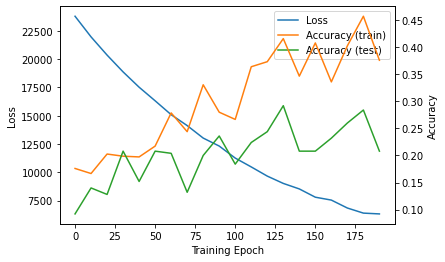

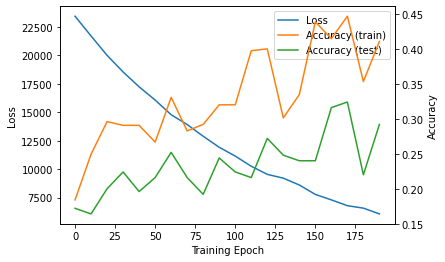

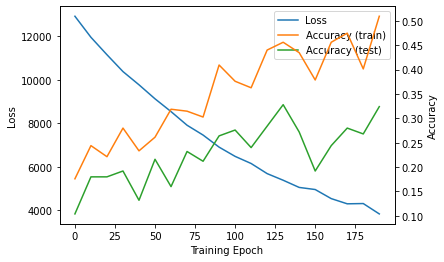

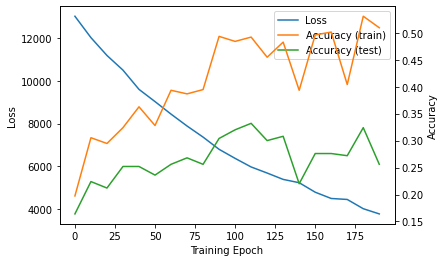

In [ ]:
### CLASSIFY cifar10 PICTURES WITH DIFF WEIGHT INITIALIZATIONS 
## ALPHA = 0.005
## CROSS ENTROPY LOSS FUNCTION

# create a dataset of 1000 CIFAR-10 images, reshaped as single vectors, and labels
data = cifar10.load_data()

X = data[0][0][:1000].reshape([1000,32*32*3])
Y = data[0][1][:1000]

# randomly choose 75% of the data to be the training set and 25% for the testing set
(trainX, testX, trainY, testY) = train_test_split(X, Y, test_size = 0.25, random_state=1)

# normalize the data
trainX = normalize(trainX)
testX = normalize(testX)

print("\n***** layers: [3072, 512, 64, 10]")
# fit the model to the training data
model = FeedforwardNeuralNetwork([3072, 512, 64, 10], 0.005, 1.0, 10.0, 32, 0.6, ['normal', 1], 'sigmoid', 'cross-entropy')
model.fit(trainX, trainY, testX, testY, 200, 10)

print("Training set accuracy")
trainY = LabelBinarizer().fit_transform(trainY)
predictedY = model.predict(trainX)
predictedY = predictedY.argmax(axis=1)
trainY = trainY.argmax(axis=1)
print(accuracy_score(trainY, predictedY))

print("Test set accuracy")
testY = LabelBinarizer().fit_transform(testY)
predictedY = model.predict(testX)
predictedY = predictedY.argmax(axis=1)
testY = testY.argmax(axis=1)
print(accuracy_score(testY, predictedY))

print("\n***** layers: [3072, 512, 32, 10]")
# fit the model to the training data
model = FeedforwardNeuralNetwork([3072, 512, 32, 10], 0.005, 1.0, 10.0, 32, 0.6, ['normal', 1], 'sigmoid', 'cross-entropy')
model.fit(trainX, trainY, testX, testY, 200, 10)

print("Training set accuracy")
trainY = LabelBinarizer().fit_transform(trainY)
predictedY = model.predict(trainX)
predictedY = predictedY.argmax(axis=1)
trainY = trainY.argmax(axis=1)
print(accuracy_score(trainY, predictedY))

print("Test set accuracy")
testY = LabelBinarizer().fit_transform(testY)
predictedY = model.predict(testX)
predictedY = predictedY.argmax(axis=1)
testY = testY.argmax(axis=1)
print(accuracy_score(testY, predictedY))


print("\n***** layers: [3072, 256, 32, 10]")
# fit the model to the training data
model = FeedforwardNeuralNetwork([3072, 256, 32, 10], 0.005, 1.0, 10.0, 32, 0.6, ['normal', 1], 'sigmoid', 'cross-entropy')
model.fit(trainX, trainY, testX, testY, 200, 10)

print("Training set accuracy")
trainY = LabelBinarizer().fit_transform(trainY)
predictedY = model.predict(trainX)
predictedY = predictedY.argmax(axis=1)
trainY = trainY.argmax(axis=1)
print(accuracy_score(trainY, predictedY))

print("Test set accuracy")
testY = LabelBinarizer().fit_transform(testY)
predictedY = model.predict(testX)
predictedY = predictedY.argmax(axis=1)
testY = testY.argmax(axis=1)
print(accuracy_score(testY, predictedY))

print("\n***** layers: [3072, 256, 64, 10]")
# fit the model to the training data
model = FeedforwardNeuralNetwork([3072, 256, 64, 10], 0.005, 1.0, 10.0, 32, 0.6, ['normal', 1], 'sigmoid', 'cross-entropy')
model.fit(trainX, trainY, testX, testY, 200, 10)

print("Training set accuracy")
trainY = LabelBinarizer().fit_transform(trainY)
predictedY = model.predict(trainX)
predictedY = predictedY.argmax(axis=1)
trainY = trainY.argmax(axis=1)
print(accuracy_score(trainY, predictedY))

print("Test set accuracy")
testY = LabelBinarizer().fit_transform(testY)
predictedY = model.predict(testX)
predictedY = predictedY.argmax(axis=1)
testY = testY.argmax(axis=1)
print(accuracy_score(testY, predictedY))


Adding some additional layers


***** layers: [3072, 512, 32, 16, 10]
Training set accuracy
0.38266666666666665
Test set accuracy
0.24

***** layers: [3072, 256, 64, 32, 10]
Training set accuracy
0.396
Test set accuracy
0.26

***** layers: [3072, 256, 64, 16, 10]
Training set accuracy
0.388
Test set accuracy
0.276


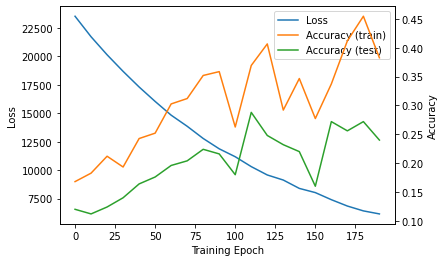

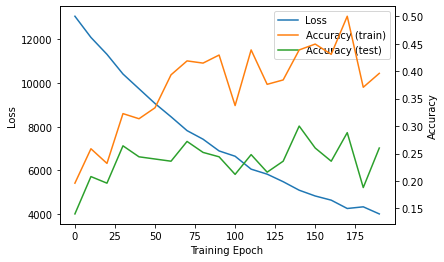

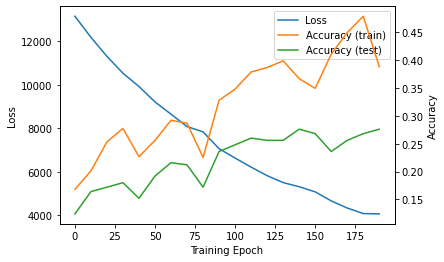

In [ ]:
### CLASSIFY cifar10 PICTURES WITH DIFF WEIGHT INITIALIZATIONS 
## ALPHA = 0.005
## CROSS ENTROPY LOSS FUNCTION

# create a dataset of 1000 CIFAR-10 images, reshaped as single vectors, and labels
data = cifar10.load_data()

X = data[0][0][:1000].reshape([1000,32*32*3])
Y = data[0][1][:1000]

# randomly choose 75% of the data to be the training set and 25% for the testing set
(trainX, testX, trainY, testY) = train_test_split(X, Y, test_size = 0.25, random_state=1)

# normalize the data
trainX = normalize(trainX)
testX = normalize(testX)

print("\n***** layers: [3072, 512, 32, 16, 10]")
# fit the model to the training data
model = FeedforwardNeuralNetwork([3072, 512, 32, 16, 10], 0.005, 1.0, 10.0, 32, 0.6, ['normal', 1], 'sigmoid', 'cross-entropy')
model.fit(trainX, trainY, testX, testY, 200, 10)

print("Training set accuracy")
trainY = LabelBinarizer().fit_transform(trainY)
predictedY = model.predict(trainX)
predictedY = predictedY.argmax(axis=1)
trainY = trainY.argmax(axis=1)
print(accuracy_score(trainY, predictedY))

print("Test set accuracy")
testY = LabelBinarizer().fit_transform(testY)
predictedY = model.predict(testX)
predictedY = predictedY.argmax(axis=1)
testY = testY.argmax(axis=1)
print(accuracy_score(testY, predictedY))

print("\n***** layers: [3072, 256, 64, 32, 10]")
# fit the model to the training data
model = FeedforwardNeuralNetwork([3072, 256, 64, 32, 10], 0.005, 1.0, 10.0, 32, 0.6, ['normal', 1], 'sigmoid', 'cross-entropy')
model.fit(trainX, trainY, testX, testY, 200, 10)

print("Training set accuracy")
trainY = LabelBinarizer().fit_transform(trainY)
predictedY = model.predict(trainX)
predictedY = predictedY.argmax(axis=1)
trainY = trainY.argmax(axis=1)
print(accuracy_score(trainY, predictedY))

print("Test set accuracy")
testY = LabelBinarizer().fit_transform(testY)
predictedY = model.predict(testX)
predictedY = predictedY.argmax(axis=1)
testY = testY.argmax(axis=1)
print(accuracy_score(testY, predictedY))

print("\n***** layers: [3072, 256, 64, 16, 10]")
# fit the model to the training data
model = FeedforwardNeuralNetwork([3072, 256, 64, 16, 10], 0.005, 1.0, 10.0, 32, 0.6, ['normal', 1], 'sigmoid', 'cross-entropy')
model.fit(trainX, trainY, testX, testY, 200, 10)

print("Training set accuracy")
trainY = LabelBinarizer().fit_transform(trainY)
predictedY = model.predict(trainX)
predictedY = predictedY.argmax(axis=1)
trainY = trainY.argmax(axis=1)
print(accuracy_score(trainY, predictedY))

print("Test set accuracy")
testY = LabelBinarizer().fit_transform(testY)
predictedY = model.predict(testX)
predictedY = predictedY.argmax(axis=1)
testY = testY.argmax(axis=1)
print(accuracy_score(testY, predictedY))


So it looks like adding an adiitional layer did not help the model and only added comuptation time. Now I will run the best two architecures again and seee how well they do.


***** layers: [3072, 512, 32, 10]
Training set accuracy
0.42933333333333334
Test set accuracy
0.26

***** layers: [3072, 256, 64, 10]
Training set accuracy
0.5706666666666667
Test set accuracy
0.316


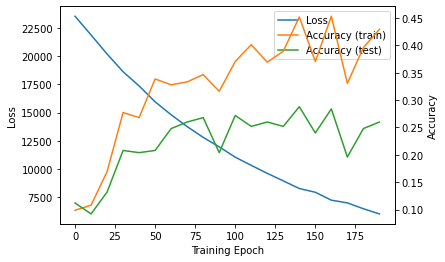

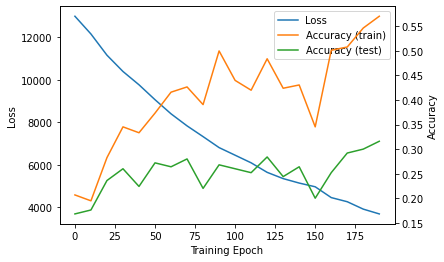

In [ ]:
### CLASSIFY cifar10 PICTURES WITH DIFF WEIGHT INITIALIZATIONS 
## ALPHA = 0.005
## CROSS ENTROPY LOSS FUNCTION

# create a dataset of 1000 CIFAR-10 images, reshaped as single vectors, and labels
data = cifar10.load_data()

X = data[0][0][:1000].reshape([1000,32*32*3])
Y = data[0][1][:1000]

# randomly choose 75% of the data to be the training set and 25% for the testing set
(trainX, testX, trainY, testY) = train_test_split(X, Y, test_size = 0.25, random_state=1)

# normalize the data
trainX = normalize(trainX)
testX = normalize(testX)

print("\n***** layers: [3072, 512, 32, 10]")
# fit the model to the training data
model = FeedforwardNeuralNetwork([3072, 512, 32, 10], 0.005, 1.0, 10.0, 32, 0.6, ['normal', 1], 'sigmoid', 'cross-entropy')
model.fit(trainX, trainY, testX, testY, 200, 10)

print("Training set accuracy")
trainY = LabelBinarizer().fit_transform(trainY)
predictedY = model.predict(trainX)
predictedY = predictedY.argmax(axis=1)
trainY = trainY.argmax(axis=1)
print(accuracy_score(trainY, predictedY))

print("Test set accuracy")
testY = LabelBinarizer().fit_transform(testY)
predictedY = model.predict(testX)
predictedY = predictedY.argmax(axis=1)
testY = testY.argmax(axis=1)
print(accuracy_score(testY, predictedY))

print("\n***** layers: [3072, 256, 64, 10]")
# fit the model to the training data
model = FeedforwardNeuralNetwork([3072, 256, 64, 10], 0.005, 1.0, 10.0, 32, 0.6, ['normal', 1], 'sigmoid', 'cross-entropy')
model.fit(trainX, trainY, testX, testY, 200, 10)

print("Training set accuracy")
trainY = LabelBinarizer().fit_transform(trainY)
predictedY = model.predict(trainX)
predictedY = predictedY.argmax(axis=1)
trainY = trainY.argmax(axis=1)
print(accuracy_score(trainY, predictedY))

print("Test set accuracy")
testY = LabelBinarizer().fit_transform(testY)
predictedY = model.predict(testX)
predictedY = predictedY.argmax(axis=1)
testY = testY.argmax(axis=1)
print(accuracy_score(testY, predictedY))



##Activation Functions

Previously we used the signmoid activation function, let's see what happens when we used ELU instead


***** layers: [3072, 256, 64, 10]
 uniform, -0.1, 0.1


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:315: RuntimeWarning: invalid value encountered in log


Training set accuracy
0.4493333333333333
Test set accuracy
0.272

***** layers: [3072, 256, 64, 10]
 LeCun, uniform


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:315: RuntimeWarning: invalid value encountered in log


Training set accuracy
0.41733333333333333
Test set accuracy
0.228

***** layers: [3072, 256, 64, 10]
 LeCun, normal


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:315: RuntimeWarning: invalid value encountered in log


Training set accuracy
0.47333333333333333
Test set accuracy
0.288

***** layers: [3072, 256, 64, 10]
 He, uniform


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:315: RuntimeWarning: invalid value encountered in log


Training set accuracy
0.42533333333333334
Test set accuracy
0.288


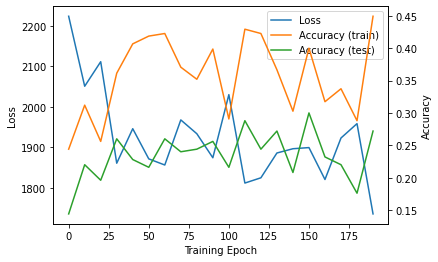

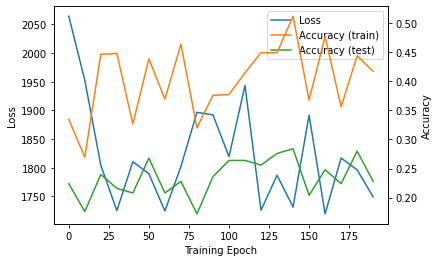

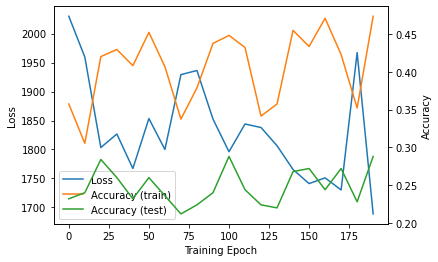

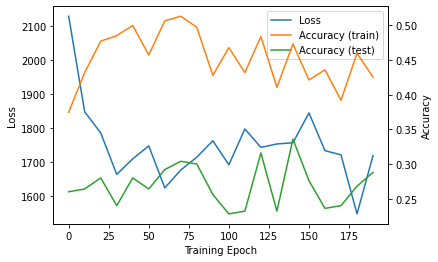

In [ ]:
### CLASSIFY cifar10 PICTURES WITH DIFF WEIGHT INITIALIZATIONS 
## ALPHA = 0.005
## CROSS ENTROPY LOSS FUNCTION

# create a dataset of 1000 CIFAR-10 images, reshaped as single vectors, and labels
data = cifar10.load_data()

X = data[0][0][:1000].reshape([1000,32*32*3])
Y = data[0][1][:1000]

# randomly choose 75% of the data to be the training set and 25% for the testing set
(trainX, testX, trainY, testY) = train_test_split(X, Y, test_size = 0.25, random_state=1)

# normalize the data
trainX = normalize(trainX)
testX = normalize(testX)

print("\n***** layers: [3072, 256, 64, 10]\n uniform, -0.1, 0.1")
# fit the model to the training data
model = FeedforwardNeuralNetwork([3072, 256, 64, 10], 0.01, 1.0, 10.0, 32, 0.6, ['uniform', -0.1, 0.1], 'ELU', 'cross-entropy')
model.fit(trainX, trainY, testX, testY, 200, 10)

print("Training set accuracy")
trainY = LabelBinarizer().fit_transform(trainY)
predictedY = model.predict(trainX)
predictedY = predictedY.argmax(axis=1)
trainY = trainY.argmax(axis=1)
print(accuracy_score(trainY, predictedY))

print("Test set accuracy")
testY = LabelBinarizer().fit_transform(testY)
predictedY = model.predict(testX)
predictedY = predictedY.argmax(axis=1)
testY = testY.argmax(axis=1)
print(accuracy_score(testY, predictedY))


print("\n***** layers: [3072, 256, 64, 10]\n LeCun, uniform")
# fit the model to the training data
model = FeedforwardNeuralNetwork([3072, 256, 64, 10], 0.01, 1.0, 10.0, 32, 0.6, ['LeCun', 'uniform'], 'ELU', 'cross-entropy')
model.fit(trainX, trainY, testX, testY, 200, 10)

print("Training set accuracy")
trainY = LabelBinarizer().fit_transform(trainY)
predictedY = model.predict(trainX)
predictedY = predictedY.argmax(axis=1)
trainY = trainY.argmax(axis=1)
print(accuracy_score(trainY, predictedY))

print("Test set accuracy")
testY = LabelBinarizer().fit_transform(testY)
predictedY = model.predict(testX)
predictedY = predictedY.argmax(axis=1)
testY = testY.argmax(axis=1)
print(accuracy_score(testY, predictedY))

print("\n***** layers: [3072, 256, 64, 10]\n LeCun, normal")
# fit the model to the training data
model = FeedforwardNeuralNetwork([3072, 256, 64, 10], 0.01, 1.0, 10.0, 32, 0.6, ['LeCun', 'normal'], 'ELU', 'cross-entropy')
model.fit(trainX, trainY, testX, testY, 200, 10)

print("Training set accuracy")
trainY = LabelBinarizer().fit_transform(trainY)
predictedY = model.predict(trainX)
predictedY = predictedY.argmax(axis=1)
trainY = trainY.argmax(axis=1)
print(accuracy_score(trainY, predictedY))

print("Test set accuracy")
testY = LabelBinarizer().fit_transform(testY)
predictedY = model.predict(testX)
predictedY = predictedY.argmax(axis=1)
testY = testY.argmax(axis=1)
print(accuracy_score(testY, predictedY))


print("\n***** layers: [3072, 256, 64, 10]\n He, uniform")
# fit the model to the training data
model = FeedforwardNeuralNetwork([3072, 256, 64, 10], 0.01, 1.0, 10.0, 32, 0.6, ['He', 'uniform'], 'ELU', 'cross-entropy')
model.fit(trainX, trainY, testX, testY, 200, 10)

print("Training set accuracy")
trainY = LabelBinarizer().fit_transform(trainY)
predictedY = model.predict(trainX)
predictedY = predictedY.argmax(axis=1)
trainY = trainY.argmax(axis=1)
print(accuracy_score(trainY, predictedY))

print("Test set accuracy")
testY = LabelBinarizer().fit_transform(testY)
predictedY = model.predict(testX)
predictedY = predictedY.argmax(axis=1)
testY = testY.argmax(axis=1)
print(accuracy_score(testY, predictedY))


***** ELU ******
 Uniform (-0.1,0.1)


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:315: RuntimeWarning: invalid value encountered in log


Training set accuracy
0.7264
Test set accuracy
0.364

***** ELU *****
 He, Uniform


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:315: RuntimeWarning: invalid value encountered in log


Training set accuracy
0.6621333333333334
Test set accuracy
0.3696


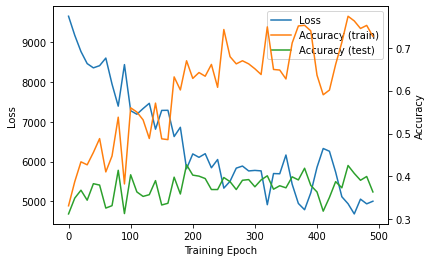

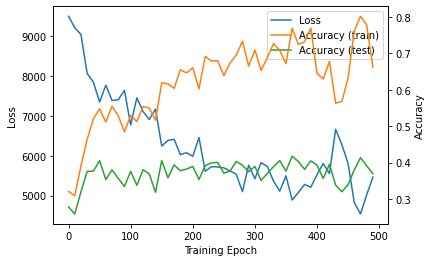

In [ ]:
### CLASSIFY cifar10 PICTURES WITH DIFF WEIGHT INITIALIZATIONS 
## ALPHA = 0.005
## CROSS ENTROPY LOSS FUNCTION

# create a dataset of 1000 CIFAR-10 images, reshaped as single vectors, and labels
data = cifar10.load_data()

X = data[0][0][:5000].reshape([5000,32*32*3])
Y = data[0][1][:5000]

# randomly choose 75% of the data to be the training set and 25% for the testing set
(trainX, testX, trainY, testY) = train_test_split(X, Y, test_size = 0.25, random_state=1)

# normalize the data
trainX = normalize(trainX)
testX = normalize(testX)

print("\n***** ELU ******\n Uniform (-0.1,0.1)")
# fit the model to the training data
model = FeedforwardNeuralNetwork([3072, 256, 64, 10], 0.01, 1.0, 10.0, 32, 0.6, ['uniform', -0.1, 0.1], 'ELU', 'cross-entropy')
model.fit(trainX, trainY, testX, testY, 500, 10)

print("Training set accuracy")
trainY = LabelBinarizer().fit_transform(trainY)
predictedY = model.predict(trainX)
predictedY = predictedY.argmax(axis=1)
trainY = trainY.argmax(axis=1)
print(accuracy_score(trainY, predictedY))

print("Test set accuracy")
testY = LabelBinarizer().fit_transform(testY)
predictedY = model.predict(testX)
predictedY = predictedY.argmax(axis=1)
testY = testY.argmax(axis=1)
print(accuracy_score(testY, predictedY))

print("\n***** ELU *****\n He, Uniform")
# fit the model to the training data
model = FeedforwardNeuralNetwork([3072, 256, 64, 10], 0.01, 1.0, 10.0, 32, 0.6, ['He', 'uniform'], 'ELU', 'cross-entropy')
model.fit(trainX, trainY, testX, testY, 500, 10)

print("Training set accuracy")
trainY = LabelBinarizer().fit_transform(trainY)
predictedY = model.predict(trainX)
predictedY = predictedY.argmax(axis=1)
trainY = trainY.argmax(axis=1)
print(accuracy_score(trainY, predictedY))

print("Test set accuracy")
testY = LabelBinarizer().fit_transform(testY)
predictedY = model.predict(testX)
predictedY = predictedY.argmax(axis=1)
testY = testY.argmax(axis=1)
print(accuracy_score(testY, predictedY))

#Final Thoughts
Looking at the results of different activation functions, I realized that I depending on the actvation functionbeing used, weight initialiation can make a big difference. Most notably, the uniform distribution performed very poorly with sigmoid activation but pretty well with reLu/ELU. This has to do with the shape of the function and its derivative, mkaing some weight initializations more effective than others. 